In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
from core.classifiers.fc_net import *
from core.data_utils import get_CIFAR10_data
from core.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from core.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Affine layer: foward

In [9]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print 'Testing affine_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing affine_forward function:
difference:  9.76984772881e-10


# Affine layer: backward
Implement backprop for affine layer and test using numeric gradient checking.

In [10]:
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print 'Testing affine_backward function:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_backward function:
dx error:  1.17787605708e-10
dw error:  1.48517045557e-10
db error:  1.37022388091e-10


# ReLU layer: forward

In [11]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

print 'Testing relu_forward function:'
print 'difference: ', rel_error(out, correct_out)

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward

In [12]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

print 'Testing relu_backward function:'
print 'dx error: ', rel_error(dx_num, dx)

Testing relu_backward function:
dx error:  3.27561651454e-12


# Combine affine and relu layers

In [13]:
from core.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print 'Testing affine_relu_forward:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing affine_relu_forward:
dx error:  5.99966295267e-11
dw error:  9.67817828473e-11
db error:  2.54800079449e-11


# Loss layers: Softmax and SVM

In [14]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print 'Testing svm_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print '\nTesting softmax_loss:'
print 'loss: ', loss
print 'dx error: ', rel_error(dx_num, dx)

Testing svm_loss:
loss:  9.0015807085
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.30274363907
dx error:  1.06559733081e-08


# Two-layer network

In [15]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print 'Testing initialization ... '
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print 'Testing test-time forward pass ... '
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print 'Testing training loss (no regularization)'
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print 'Running numeric gradient check with reg = ', reg
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.32e-10
b1 relative error: 8.37e-09
b2 relative error: 2.53e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 8.89e-10


# Solver

In [16]:
model = TwoLayerNet(input_dim=32*32*3, hidden_dim=100, num_classes=10, weight_scale=1e-2)
solver = None

print data.keys
data = {
    'X_train': data['X_train'], # training data
    'y_train': data['y_train'], # training labels
    'X_val': data['X_val'], # validation data
    'y_val': data['y_val'] # validation labels
}
solver = Solver(model, data,
              update_rule='sgd',
              optim_config={
                'learning_rate': 1e-3,
              },
              lr_decay=0.95,
              num_epochs=10, batch_size=100,
              print_every=100)
solver.train()

<built-in method keys of dict object at 0x1113aa168>
(Iteration 1 / 4900) loss: 4.777595
(Epoch 0 / 10) train acc: 0.125000; val_acc: 0.145000
(Iteration 101 / 4900) loss: 1.931096
(Iteration 201 / 4900) loss: 1.765763
(Iteration 301 / 4900) loss: 1.741536
(Iteration 401 / 4900) loss: 1.732143
(Epoch 1 / 10) train acc: 0.392000; val_acc: 0.410000
(Iteration 501 / 4900) loss: 1.700481
(Iteration 601 / 4900) loss: 1.979871
(Iteration 701 / 4900) loss: 1.435441
(Iteration 801 / 4900) loss: 1.720131
(Iteration 901 / 4900) loss: 1.413031
(Epoch 2 / 10) train acc: 0.477000; val_acc: 0.445000
(Iteration 1001 / 4900) loss: 1.434993
(Iteration 1101 / 4900) loss: 1.255350
(Iteration 1201 / 4900) loss: 1.455398
(Iteration 1301 / 4900) loss: 1.562190
(Iteration 1401 / 4900) loss: 1.476714
(Epoch 3 / 10) train acc: 0.477000; val_acc: 0.467000
(Iteration 1501 / 4900) loss: 1.538178
(Iteration 1601 / 4900) loss: 1.307928
(Iteration 1701 / 4900) loss: 1.488314
(Iteration 1801 / 4900) loss: 1.389542
(I

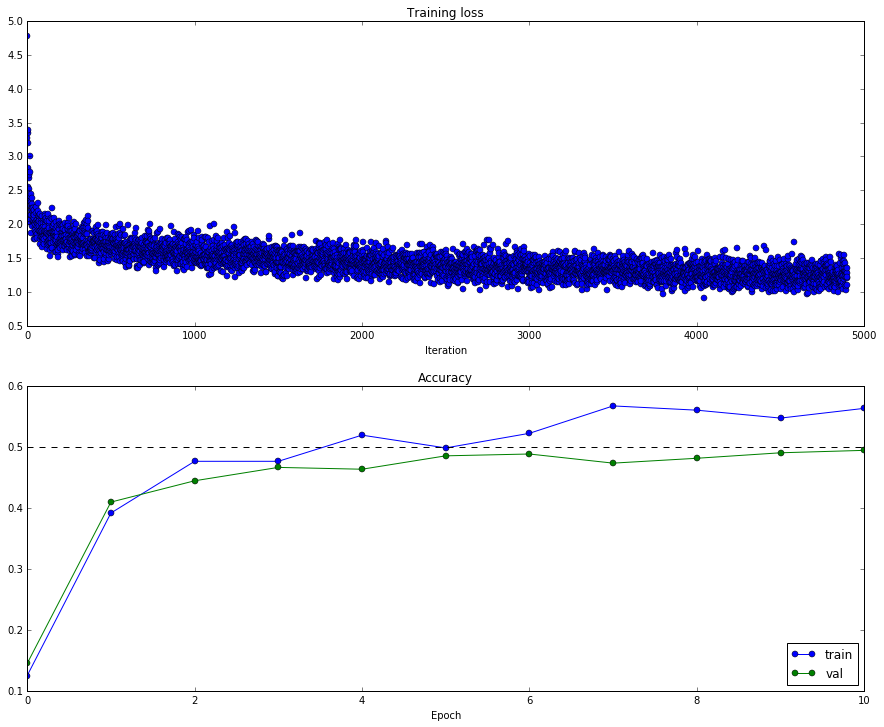

In [17]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [63]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print 'Running check with reg = ', reg
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print 'Initial loss: ', loss

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print '%s relative error: %.2e' % (name, rel_error(grad_num, grads[name]))

Running check with reg =  0
Initial loss:  2.30326537076
W1 relative error: 2.43e-06
W2 relative error: 4.37e-06
W3 relative error: 2.09e-06
b1 relative error: 1.49e-08
b2 relative error: 6.27e-08
b3 relative error: 1.38e-10
Running check with reg =  3.14
Initial loss:  6.80857502667
W1 relative error: 3.27e-07
W2 relative error: 1.36e-08
W3 relative error: 6.21e-07
b1 relative error: 1.58e-08
b2 relative error: 1.00e-07
b3 relative error: 1.42e-10


As another sanity check, overfit a small dataset of 50 images. overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.291976
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.126000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.151000
(Epoch 2 / 20) train acc: 0.480000; val_acc: 0.198000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.186000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.157000
(Epoch 5 / 20) train acc: 0.420000; val_acc: 0.148000
(Iteration 11 / 40) loss: 1.606268
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.194000
(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.203000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.193000
(Epoch 9 / 20) train acc: 0.820000; val_acc: 0.201000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.178000
(Iteration 21 / 40) loss: 0.429654
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.201000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.199000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.183000
(Epoch 14 / 20) train acc: 0.860000; val_acc: 0.178000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.172000
(Iteration 31 / 40) loss: 

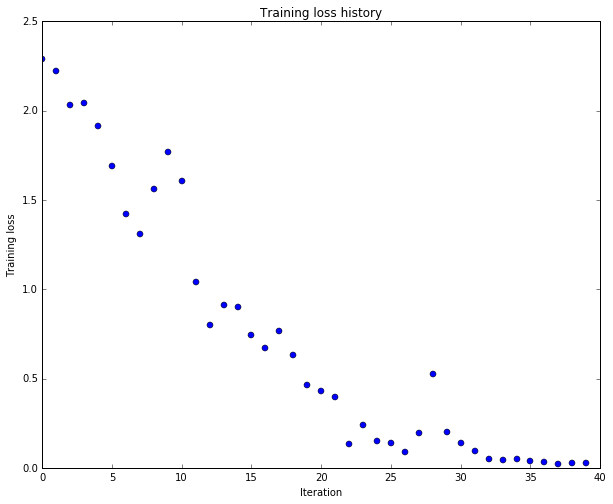

In [69]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Use Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Much harder to train

(Iteration 1 / 40) loss: 2.328782
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.077000
(Epoch 2 / 20) train acc: 0.220000; val_acc: 0.085000
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.092000
(Epoch 4 / 20) train acc: 0.320000; val_acc: 0.092000
(Epoch 5 / 20) train acc: 0.500000; val_acc: 0.099000
(Iteration 11 / 40) loss: 1.641211
(Epoch 6 / 20) train acc: 0.660000; val_acc: 0.146000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.144000
(Epoch 8 / 20) train acc: 0.800000; val_acc: 0.168000
(Epoch 9 / 20) train acc: 0.580000; val_acc: 0.108000
(Epoch 10 / 20) train acc: 0.420000; val_acc: 0.091000
(Iteration 21 / 40) loss: 1.269030
(Epoch 11 / 20) train acc: 0.900000; val_acc: 0.204000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.225000
(Epoch 13 / 20) train acc: 0.900000; val_acc: 0.175000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.186000
(Epoch 15 / 20) train acc: 0.940000; val_acc: 0.172000
(Iteration 31 / 40) loss: 

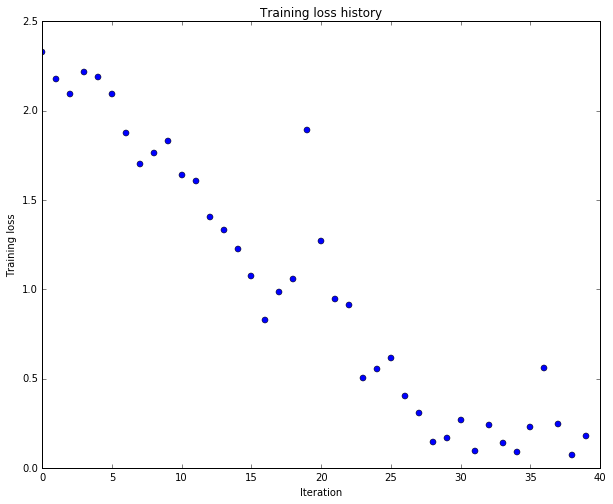

In [80]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 0.02
weight_scale = 0.03
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Update rules

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

In [82]:
from core.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print 'next_w error: ', rel_error(next_w, expected_next_w)
print 'velocity error: ', rel_error(expected_velocity, config['velocity'])

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Train a six-layer network with both SGD and SGD+momentum. Can see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.838784
(Epoch 0 / 5) train acc: 0.108000; val_acc: 0.130000
(Iteration 11 / 200) loss: 2.118817
(Iteration 21 / 200) loss: 2.049340
(Iteration 31 / 200) loss: 2.115032
(Epoch 1 / 5) train acc: 0.281000; val_acc: 0.267000
(Iteration 41 / 200) loss: 2.124657
(Iteration 51 / 200) loss: 1.901176
(Iteration 61 / 200) loss: 1.924714
(Iteration 71 / 200) loss: 1.893586
(Epoch 2 / 5) train acc: 0.341000; val_acc: 0.317000
(Iteration 81 / 200) loss: 1.930078
(Iteration 91 / 200) loss: 2.055809
(Iteration 101 / 200) loss: 1.872465
(Iteration 111 / 200) loss: 1.702901
(Epoch 3 / 5) train acc: 0.375000; val_acc: 0.328000
(Iteration 121 / 200) loss: 1.756231
(Iteration 131 / 200) loss: 1.802285
(Iteration 141 / 200) loss: 1.757293
(Iteration 151 / 200) loss: 1.700797
(Epoch 4 / 5) train acc: 0.379000; val_acc: 0.346000
(Iteration 161 / 200) loss: 1.955034
(Iteration 171 / 200) loss: 1.708740
(Iteration 181 / 200) loss: 1.595048
(Iteration 191 / 200) los

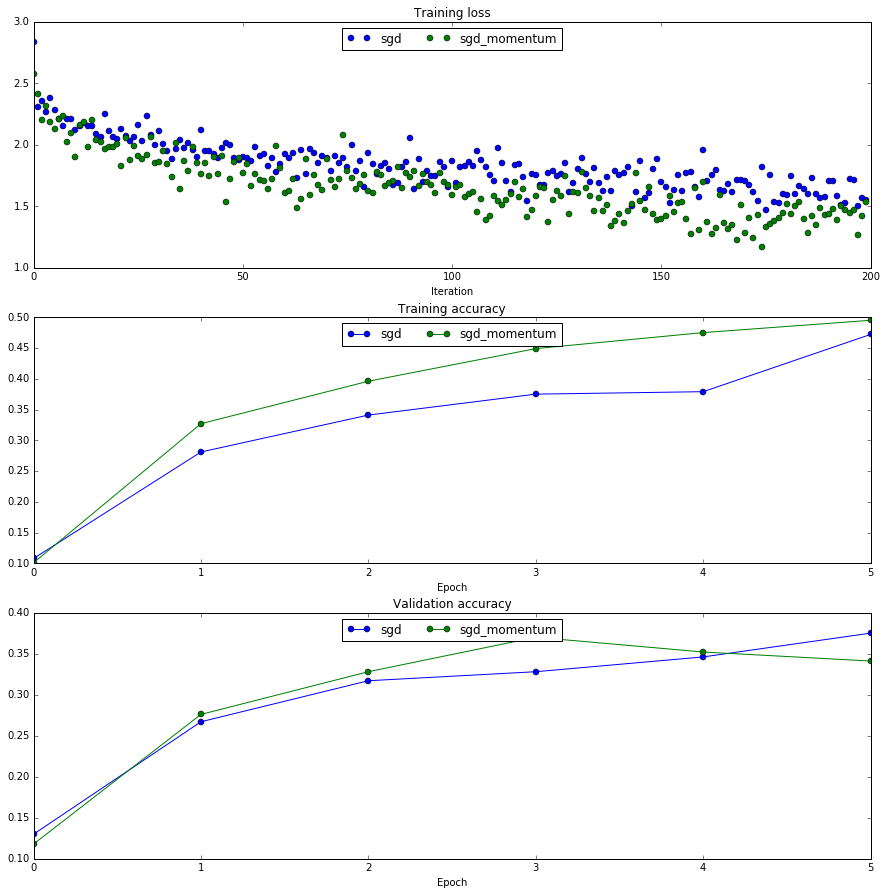

In [83]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print 'running with ', update_rule
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp and Adam are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In [93]:
from core.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print 'next_w error: ', rel_error(expected_next_w, next_w)
print 'cache error: ', rel_error(expected_cache, config['cache'])

next_w error:  9.50264522989e-08
cache error:  2.64779558072e-09


In [97]:
from core.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print 'next_w error: ', rel_error(expected_next_w, next_w)
print 'v error: ', rel_error(expected_v, config['v'])
print 'm error: ', rel_error(expected_m, config['m'])

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Train a pair of deep networks using RMSProp and Adam:

running with  adam
(Iteration 1 / 200) loss: 2.611581
(Epoch 0 / 5) train acc: 0.149000; val_acc: 0.143000
(Iteration 11 / 200) loss: 2.029840
(Iteration 21 / 200) loss: 1.767092
(Iteration 31 / 200) loss: 1.835112
(Epoch 1 / 5) train acc: 0.368000; val_acc: 0.327000
(Iteration 41 / 200) loss: 1.781965
(Iteration 51 / 200) loss: 1.742191
(Iteration 61 / 200) loss: 1.532969
(Iteration 71 / 200) loss: 1.624189
(Epoch 2 / 5) train acc: 0.440000; val_acc: 0.333000
(Iteration 81 / 200) loss: 1.567826
(Iteration 91 / 200) loss: 1.493316
(Iteration 101 / 200) loss: 1.553915
(Iteration 111 / 200) loss: 1.409930
(Epoch 3 / 5) train acc: 0.510000; val_acc: 0.349000
(Iteration 121 / 200) loss: 1.401542
(Iteration 131 / 200) loss: 1.275050
(Iteration 141 / 200) loss: 1.426567
(Iteration 151 / 200) loss: 1.267501
(Epoch 4 / 5) train acc: 0.546000; val_acc: 0.383000
(Iteration 161 / 200) loss: 1.296375
(Iteration 171 / 200) loss: 1.289426
(Iteration 181 / 200) loss: 1.368967
(Iteration 191 / 200) lo

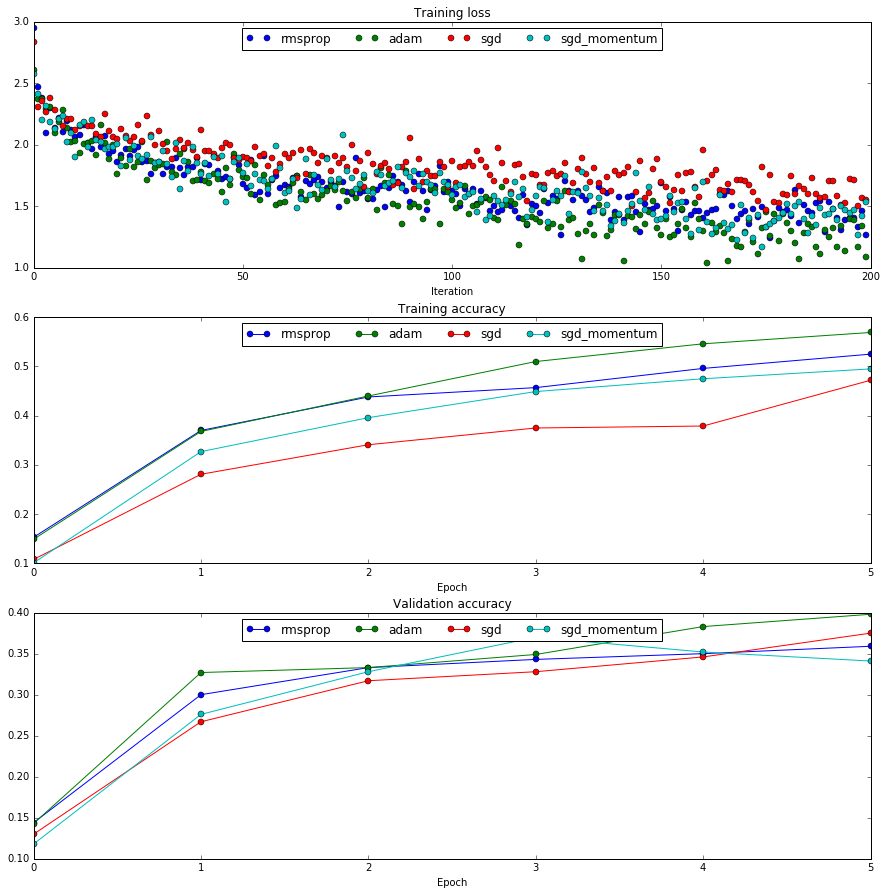

In [98]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print 'running with ', update_rule
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.iteritems():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()